## Ninjacart

Ninjacart is India's largest fresh produce supply chain company, connecting producers directly with the retailers. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

In [1]:
# !pip install -U Pillow

In [2]:
# !pip install seaborn -q

In [3]:
import os
import glob
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check if TensorFlow is built with GPU support
print("Built with GPU support:", tf.test.is_built_with_cuda())

# List available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print("GPU Devices:", physical_devices)

Built with GPU support: False
Num GPUs Available:  0
GPU Devices: []


In [5]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [6]:
# !nvidia-smi

## Getting to know the dataset

In [7]:
len(os.listdir('ninjacart_data/train/tomato')), len(os.listdir('ninjacart_data/train/onion')), len(os.listdir('ninjacart_data/train/potato')), len(os.listdir('ninjacart_data/train/indian market'))

(789, 849, 898, 599)

In [8]:
from PIL import Image

choose_category = np.random.choice(['tomato', 'onion', 'potato', 'indian market'])
pick_random_image = os.listdir(f'ninjacart_data/train/{choose_category}')[np.random.randint(0, 100)] 
image = Image.open(os.path.join(os.getcwd(), f"ninjacart_data/train/{choose_category}", pick_random_image))
width, height = image.size

print(f"Image width: {width}px")
print(f"Image height: {height}px")

Image width: 270px
Image height: 187px


potato potato11158 (2).jpeg


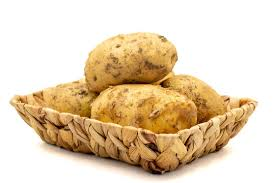

In [9]:
choose_category = np.random.choice(['tomato', 'onion', 'potato', 'indian market'])
pick_random_image = os.listdir(f'ninjacart_data/train/{choose_category}')[np.random.randint(0, 100)] 
image = Image.open(os.path.join(os.getcwd(), f"ninjacart_data/train/{choose_category}", pick_random_image))
print(choose_category, pick_random_image)
image.show()

In [10]:
train_path = 'ninjacart_data/train'
test_path = 'ninjacart_data/test'
class_names = ['indian market', 'onion', 'potato', 'tomato']

# setting up a standard size for dataset image resizing
IMAGE_SIZE = (256, 256)
SEED = 1234
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

In [11]:
train_lens = []
test_lens = []
for class_ in class_names:
    train_len, test_len = len(os.listdir(os.path.join(train_path, class_))), len(os.listdir(os.path.join(test_path, class_)))
    train_lens.append(train_len)
    test_lens.append(test_len)
    print("Class name: ", class_, " train size: ", train_len, " test: ", test_len)

Class name:  indian market  train size:  599  test:  81
Class name:  onion  train size:  849  test:  83
Class name:  potato  train size:  898  test:  81
Class name:  tomato  train size:  789  test:  106


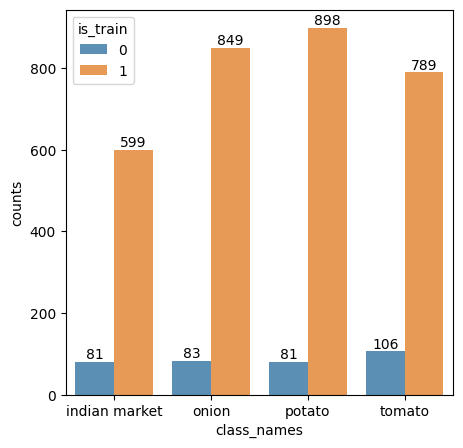

In [12]:
data_distn = pd.DataFrame({'class_names': class_names+class_names, 'counts': train_lens+test_lens, 'is_train': [1]*4+[0]*4})
plt.figure(figsize=(5, 5))
fig = sns.barplot(data_distn, x="class_names", y="counts", hue="is_train", alpha=0.8)

for bars in fig.containers:
    fig.bar_label(bars, fmt='%.0f')
plt.show()

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       batch_size = 32,
                                                       image_size = IMAGE_SIZE,
                                                       seed = SEED,
                                                       validation_split = VALIDATION_SPLIT,
                                                       subset = "training",
                                                       shuffle=True)

Found 3135 files belonging to 4 classes.
Using 2508 files for training.


In [14]:
valid_ds = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       label_mode = 'categorical',
                                                       batch_size = BATCH_SIZE,
                                                       image_size = IMAGE_SIZE,
                                                       seed = SEED,
                                                       validation_split = VALIDATION_SPLIT,
                                                       subset = "validation")

Found 3135 files belonging to 4 classes.
Using 627 files for validation.


In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_path,
                                                       label_mode = 'categorical',
                                                       batch_size = BATCH_SIZE,
                                                       image_size = IMAGE_SIZE,
                                                       seed = SEED,
                                                      )

Found 351 files belonging to 4 classes.


## Utils

In [16]:
def plot_metrics(history, metric_name):
    if metric_name not in history.history.keys():
        raise "Invalid metric name"
    num_epochs = len(history.history[metric_name])
    plt.figure(figsize=(5,3))
    plt.plot(np.linspace(0,num_epochs, num=num_epochs), history.history[metric_name], marker='o', linestyle='-', color="blue", label="train")
    plt.plot(np.linspace(0,num_epochs, num=num_epochs), history.history["val_"+metric_name], marker='x', linestyle='-', color="red", label="test")
    plt.title(f'{metric_name} v/s epoch')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_performance(test_path, model):
    num_samples = {k:0 for k in class_names}
    accuracy_pct = {k:0 for k in class_names}
    accuracy_scores = {k:0 for k in class_names}
    predicted_nums = {k:0 for k in class_names}
    predicted_nums_class = {k:0 for k in class_names}
    for idx, class_name in enumerate(class_names):
        print(class_name)
        market, tomato, potato, onion = 0, 0, 0, 0
        test_path_class = os.path.join(test_path, class_name)
        num_samples[class_name] = len(os.listdir(test_path_class))
        preds_class = []
        for i in os.listdir(test_path_class):        
            image = tf.keras.utils.load_img(test_path_class + "/" + str(i))
            image = tf.keras.utils.img_to_array(image)
            image = tf.image.resize(image, IMAGE_SIZE)
            image = tf.expand_dims(image, axis = 0)
    
            pred = model.predict(image)
            predicted = tf.argmax(pred, 1).numpy().item()
            if predicted == 0:
                market+= 1
            elif predicted == 1:
                onion+= 1
            elif predicted == 2:
                potato+= 1
            else:
                tomato+= 1
        print(market, onion, potato, tomato)
        for item in market, onion, potato, tomato :
            preds_class.append(item)
        print([x/num_samples[class_name] for x in preds_class])
        accuracy_pct[class_name] = [x/num_samples[class_name] for x in preds_class][idx]
        accuracy_scores[class_name] = [x/num_samples[class_name] for x in preds_class]
        predicted_nums[class_name] = preds_class[idx]
        predicted_nums_class[class_name] = preds_class
    results = (predicted_nums, predicted_nums_class, accuracy_pct, accuracy_scores, num_samples)
    return results

## 1. Simple CNN model

Using a simple CNN model with same padding and ReLU activations

In [17]:
OUTPUT_SIZE = len(class_names)

In [18]:
simple_cnn_model = tf.keras.Sequential([
                                # rescaling image size to set standard size of (256,256,3)
                                tf.keras.layers.Rescaling(1./255, input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]),

                                # CONV LAYER 1
                                tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.MaxPool2D(pool_size=(2,2)),

                                # CONV LAYER 2
                                tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                            
                                # CONV LAYER 3
                                tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                            
                                # CONV LAYER 4
                                tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')
                            ])

In [19]:
simple_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,204 (2.22 MB)

 Trainable params: 583,204 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# custom evaluation metrics for logging
auc_roc = tf.keras.metrics.AUC(curve='ROC', name="auc_roc")
auc_pr = tf.keras.metrics.AUC(curve='PR', name="auc_pr")

simple_cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss = tf.keras.losses.CategoricalCrossentropy(),
                        metrics = ['accuracy', auc_roc, auc_pr])

In [21]:
log_dir = "logs/simplecnn"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
result = simple_cnn_model.fit(train_ds, epochs=5, validation_data=valid_ds, callbacks=[tensorboard_cb])

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.3603 - auc_pr: 0.3674 - auc_roc: 0.6219 - loss: 1.3227 - val_accuracy: 0.5502 - val_auc_pr: 0.6614 - val_auc_roc: 0.8280 - val_loss: 1.0408
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.6642 - auc_pr: 0.7501 - auc_roc: 0.8833 - loss: 0.8247 - val_accuracy: 0.7241 - val_auc_pr: 0.8231 - val_auc_roc: 0.9179 - val_loss: 0.6933
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.7261 - auc_pr: 0.8121 - auc_roc: 0.9169 - loss: 0.7012 - val_accuracy: 0.7321 - val_auc_pr: 0.8330 - val_auc_roc: 0.9245 - val_loss: 0.6661
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.7472 - auc_pr: 0.8265 - auc_roc: 0.9251 - loss: 0.6627 - val_accuracy: 0.7640 - val_auc_pr: 0.8667 - val_auc_roc: 0.9415 - val_loss: 0.5867
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 305s 4s/step - accuracy: 0.7607 - auc_pr: 0.8527 - auc_roc: 0.9368 - loss: 0.6089 - val_accuracy: 0.7671 - val_auc_pr: 0.8715 - val_auc_roc: 0.9438

In [22]:
result.history

{'accuracy': [0.4645135700702667,
  0.6937798857688904,
  0.7388357520103455,
  0.7547847032546997,
  0.759968101978302],
 'auc_pr': [0.5183536410331726,
  0.7731521129608154,
  0.8187978267669678,
  0.8316196203231812,
  0.8488226532936096],
 'auc_roc': [0.7357032299041748,
  0.8967707753181458,
  0.9210346341133118,
  0.9278886318206787,
  0.9350178837776184],
 'loss': [1.1860743761062622,
  0.7793904542922974,
  0.6830555200576782,
  0.6518988609313965,
  0.6187981963157654],
 'val_accuracy': [0.5502392053604126,
  0.7240829467773438,
  0.7320573925971985,
  0.7639553546905518,
  0.7671451568603516],
 'val_auc_pr': [0.661362886428833,
  0.8231386542320251,
  0.8329861760139465,
  0.86668860912323,
  0.8714621067047119],
 'val_auc_roc': [0.8279924392700195,
  0.9178878664970398,
  0.9245032072067261,
  0.9415369629859924,
  0.943805992603302],
 'val_loss': [1.0407607555389404,
  0.6932608485221863,
  0.6661394238471985,
  0.5866875648498535,
  0.5740087032318115]}

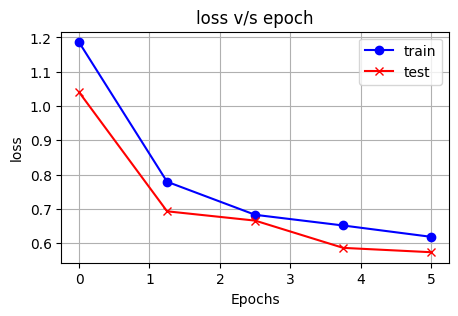

In [23]:
plot_metrics(result, "loss")

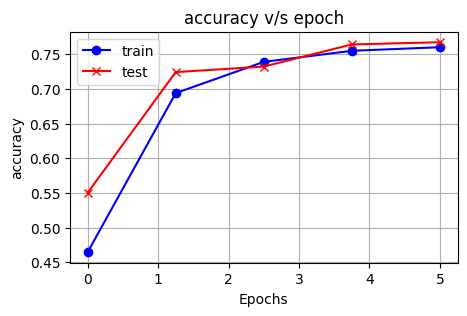

In [24]:
plot_metrics(result, "accuracy")

In [25]:
result.history

{'accuracy': [0.4645135700702667,
  0.6937798857688904,
  0.7388357520103455,
  0.7547847032546997,
  0.759968101978302],
 'auc_pr': [0.5183536410331726,
  0.7731521129608154,
  0.8187978267669678,
  0.8316196203231812,
  0.8488226532936096],
 'auc_roc': [0.7357032299041748,
  0.8967707753181458,
  0.9210346341133118,
  0.9278886318206787,
  0.9350178837776184],
 'loss': [1.1860743761062622,
  0.7793904542922974,
  0.6830555200576782,
  0.6518988609313965,
  0.6187981963157654],
 'val_accuracy': [0.5502392053604126,
  0.7240829467773438,
  0.7320573925971985,
  0.7639553546905518,
  0.7671451568603516],
 'val_auc_pr': [0.661362886428833,
  0.8231386542320251,
  0.8329861760139465,
  0.86668860912323,
  0.8714621067047119],
 'val_auc_roc': [0.8279924392700195,
  0.9178878664970398,
  0.9245032072067261,
  0.9415369629859924,
  0.943805992603302],
 'val_loss': [1.0407607555389404,
  0.6932608485221863,
  0.6661394238471985,
  0.5866875648498535,
  0.5740087032318115]}

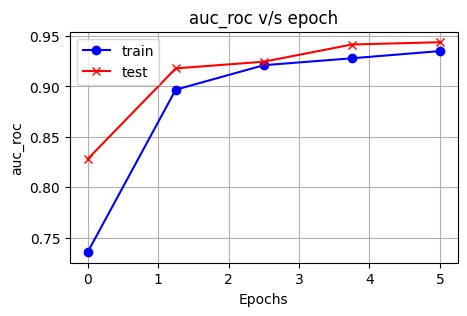

In [26]:
plot_metrics(result, 'auc_roc')

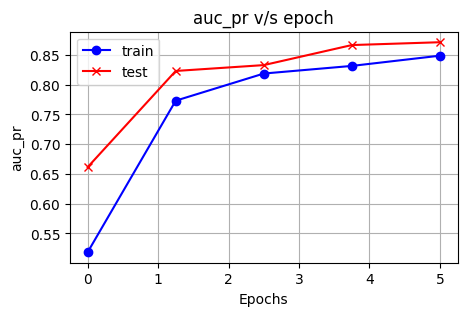

In [27]:
plot_metrics(result, 'auc_pr')

In [28]:
test_images = []

for folder in os.listdir(test_path):
  for image in os.listdir(test_path + '/' + folder):
    test_images.append(os.path.join(test_path, folder, image))

In [29]:
for i in range(5):
    image = tf.keras.utils.load_img(np.random.choice(test_images))
    image = tf.keras.utils.img_to_array(image)
    image = tf.image.resize(image, (256, 256))
    image = tf.expand_dims(image, axis = 0)
        
    pred = simple_cnn_model.predict(image)
    predicted_label = tf.argmax(pred, 1).numpy().item()
    for i in pred:
        i = tf.round((i*100))
    print("**"*50)
    print(f"-------> Actual Label: {class_names[predicted_label]}")
    print(f"-------> Prediction %: {i[0]} - {class_names[0]}")
    print(f"-------> Prediction %: {i[1]} - {class_names[1]}")
    print(f"-------> Prediction %: {i[2]} - {class_names[2]}")
    print(f"-------> Prediction %: {i[3]} - {class_names[3]}")
    print("**"*50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
****************************************************************************************************
-------> Actual Label: indian market
-------> Prediction %: 71.0 - indian market
-------> Prediction %: 24.0 - onion
-------> Prediction %: 5.0 - potato
-------> Prediction %: 0.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
****************************************************************************************************
-------> Actual Label: tomato
-------> Prediction %: 0.0 - indian market
-------> Prediction %: 0.0 - onion
-------> Prediction %: 0.0 - potato
-------> Prediction %: 99.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
****************************************************************************************************
-------> Ac

In [30]:
evaluation_results = evaluate_performance(test_path, simple_cnn_model)

indian market
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/ste

In [31]:
# evaluation_results

In [32]:
# evaluation_results[1]

In [33]:
# [l for l in evaluation_results[1].values()]

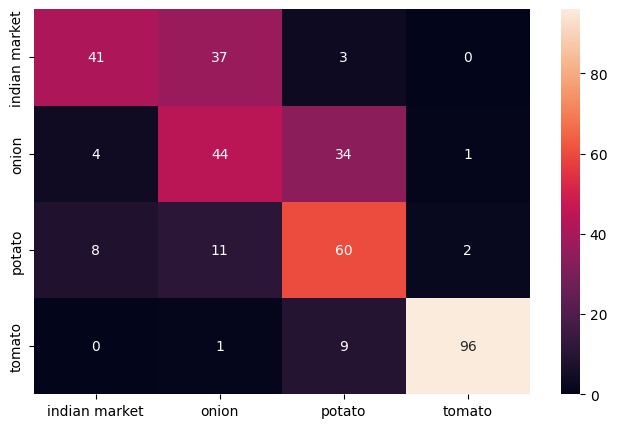

In [34]:
plt.figure(figsize=(8,5))
sns.heatmap([l for l in evaluation_results[1].values()], annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

In [35]:
model_result = simple_cnn_model.evaluate(test_ds)
dict(zip(simple_cnn_model.metrics_names, model_result))

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 943ms/step - accuracy: 0.6954 - auc_pr: 0.8109 - auc_roc: 0.9209 - loss: 0.6700


{'loss': 0.7037521600723267, 'compile_metrics': 0.6894586682319641}

## 2. Data augmentation and tuning

In [36]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor=0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2),
])

aug_ds = train_ds

for image, label in aug_ds :
  image = augmentation(image)

2024-11-02 11:53:18.151866: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
cnn_with_batch_norm_model = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    # tf.keras.layers.InputLayer(input_shape = [image_size[0], image_size[1], 3]),
    tf.keras.layers.Rescaling(1./255, input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate = 0.2),
    
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [38]:
auc_roc = tf.keras.metrics.AUC(curve='ROC', name="auc_roc")
auc_pr = tf.keras.metrics.AUC(curve='PR', name="auc_pr")

In [39]:
cnn_with_batch_norm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                    loss = tf.keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy', auc_roc, auc_pr])

In [40]:
cnn_with_batch_norm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,100 (2.23 MB)

 Trainable params: 583,652 (2.23 MB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
log_dir_tuned = "logs/cnn_with_batch_norm_model"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_tuned, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cnn_with_batch_norm_model.keras", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
results_batch_norm_model = cnn_with_batch_norm_model.fit(
                                            aug_ds,
                                            epochs=10,
                                            validation_data = valid_ds,
                                            callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb]
                                            )

Epoch 1/10


79/79 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.6523 - auc_pr: 0.7351 - auc_roc: 0.8741 - loss: 0.8215 - val_accuracy: 0.2632 - val_auc_pr: 0.4678 - val_auc_roc: 0.6212 - val_loss: 1.4005
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.7604 - auc_pr: 0.8339 - auc_roc: 0.9322 - loss: 0.6275 - val_accuracy: 0.3110 - val_auc_pr: 0.4677 - val_auc_roc: 0.6183 - val_loss: 1.5441
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.8126 - auc_pr: 0.8997 - auc_roc: 0.9598 - loss: 0.4776 - val_accuracy: 0.4338 - val_auc_pr: 0.5168 - val_auc_roc: 0.6875 - val_loss: 1.4091
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.8275 - auc_pr: 0.9111 - auc_roc: 0.9648 - loss: 0.4390 - val_accuracy: 0.4322 - val_auc_pr: 0.4661 - val_auc_roc: 0.7062 - val_loss: 1.4921
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - accuracy: 0.8341 - auc_pr: 0.9096 - auc_roc: 0.9653 - loss: 0.4388 - val_accuracy: 0.5965 - val_auc_pr: 0.7366 - val_auc_roc: 0.8597 - val

In [43]:
model_results = cnn_with_batch_norm_model.evaluate(test_ds)
dict(zip(cnn_with_batch_norm_model.metrics_names, model_results))

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 945ms/step - accuracy: 0.8188 - auc_pr: 0.9102 - auc_roc: 0.9632 - loss: 0.4606


{'loss': 0.43932878971099854, 'compile_metrics': 0.8319088220596313}

In [44]:
for i in range(5):
    image = tf.keras.utils.load_img(np.random.choice(test_images))
    image = tf.keras.utils.img_to_array(image)
    image = tf.image.resize(image, (256, 256))
    image = tf.expand_dims(image, axis = 0)
        
    pred = mode.predict(image)
    predicted_label = tf.argmax(pred, 1).numpy().item()
    for i in pred:
        i = tf.round((i*100))
    print("**"*50)
    print(f"-------> Actual Label: {class_names[predicted_label]}")
    print(f"-------> Prediction %: {i[0]} - {class_names[0]}")
    print(f"-------> Prediction %: {i[1]} - {class_names[1]}")
    print(f"-------> Prediction %: {i[2]} - {class_names[2]}")
    print(f"-------> Prediction %: {i[3]} - {class_names[3]}")
    print("**"*50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
****************************************************************************************************
-------> Actual Label: tomato
-------> Prediction %: 0.0 - indian market
-------> Prediction %: 0.0 - onion
-------> Prediction %: 0.0 - potato
-------> Prediction %: 100.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
****************************************************************************************************
-------> Actual Label: onion
-------> Prediction %: 0.0 - indian market
-------> Prediction %: 56.0 - onion
-------> Prediction %: 43.0 - potato
-------> Prediction %: 0.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
****************************************************************************************************
-------> Actual L

In [45]:
evaluation_results = evaluate_performance(test_path, cnn_with_batch_norm_model)

indian market


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

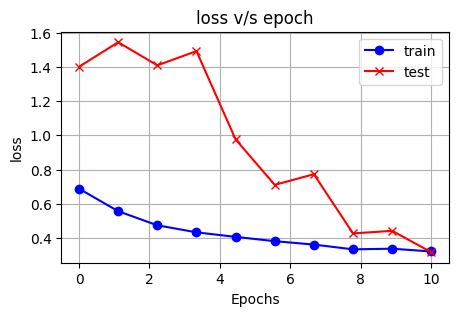

In [46]:
plot_metrics(results_batch_norm_model, "loss")

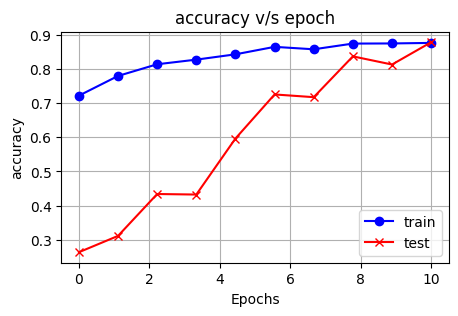

In [47]:
plot_metrics(results_batch_norm_model, "accuracy")

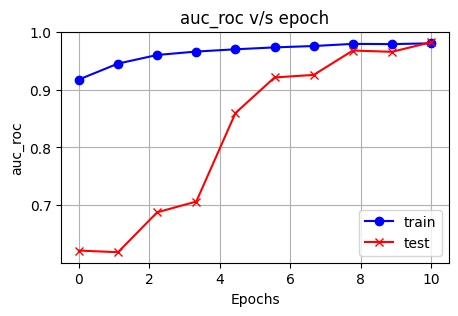

In [48]:
plot_metrics(results_batch_norm_model, "auc_roc")

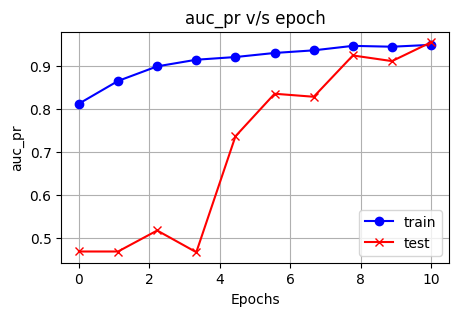

In [49]:
plot_metrics(results_batch_norm_model, "auc_pr")

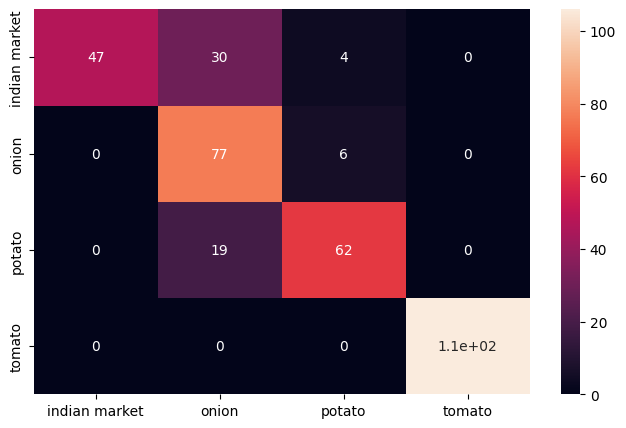

In [50]:
plt.figure(figsize=(8,5))
sns.heatmap([l for l in evaluation_results[1].values()], annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

## 3. Using mobilenet model

In [51]:
mbnet_base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(256, 256, 3), include_top = False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [52]:
model_mb = mbnet_base_model.output
model_mb = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255, input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]),
            mbnet_base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate = 0.1),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

In [53]:
log_dir_tl = "logs/mobilenet"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_tl, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mobilenet.keras", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)

In [54]:
model_mb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics = ['accuracy', auc_roc, auc_pr])

In [55]:
results_mb = model_mb.fit(aug_ds, validation_data = valid_ds, epochs = 10, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.8012 - auc_pr: 0.9147 - auc_roc: 0.9594 - loss: 0.5910 - val_accuracy: 0.9537 - val_auc_pr: 0.9943 - val_auc_roc: 0.9980 - val_loss: 0.1019
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9863 - auc_pr: 0.9992 - auc_roc: 0.9997 - loss: 0.0414 - val_accuracy: 0.9729 - val_auc_pr: 0.9966 - val_auc_roc: 0.9988 - val_loss: 0.0770
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9954 - auc_pr: 0.9999 - auc_roc: 1.0000 - loss: 0.0213 - val_accuracy: 0.9777 - val_auc_pr: 0.9950 - val_auc_roc: 0.9981 - val_loss: 0.0691
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9992 - auc_pr: 1.0000 - auc_roc: 1.0000 - loss: 0.0120 - val_accuracy: 0.9825 - val_auc_pr: 0.9982 - val_auc_roc: 0.9994 - val_loss: 0.0550
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9998 - auc_pr: 1.0000 - auc_roc: 1.0000 - loss: 0.0069 - val_accuracy: 0.9856 - val_auc_pr: 0.9988 - val_auc_roc: 0

In [56]:
model_mb.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,655,118 (36.83 MB)

 Trainable params: 3,211,076 (12.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 6,422,154 (24.50 MB)

In [57]:
model_mb_results = model_mb.evaluate(test_ds)
dict(zip(model_mb.metrics_names, model_mb_results))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9233 - auc_pr: 0.9715 - auc_roc: 0.9878 - loss: 0.2419


{'loss': 0.28131380677223206, 'compile_metrics': 0.9230769276618958}

In [58]:
for i in range(5):
    image = tf.keras.utils.load_img(np.random.choice(test_images))
    image = tf.keras.utils.img_to_array(image)
    image = tf.image.resize(image, (256, 256))
    image = tf.expand_dims(image, axis = 0)
        
    pred = model_mb.predict(image)
    predicted_label = tf.argmax(pred, 1).numpy().item()
    for i in pred:
        i = tf.round((i*100))
    print("**"*50)
    print(f"-------> Actual Label: {class_names[predicted_label]}")
    print(f"-------> Prediction %: {i[0]} - {class_names[0]}")
    print(f"-------> Prediction %: {i[1]} - {class_names[1]}")
    print(f"-------> Prediction %: {i[2]} - {class_names[2]}")
    print(f"-------> Prediction %: {i[3]} - {class_names[3]}")
    print("**"*50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
****************************************************************************************************
-------> Actual Label: indian market
-------> Prediction %: 100.0 - indian market
-------> Prediction %: 0.0 - onion
-------> Prediction %: 0.0 - potato
-------> Prediction %: 0.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
****************************************************************************************************
-------> Actual Label: onion
-------> Prediction %: 0.0 - indian market
-------> Prediction %: 90.0 - onion
-------> Prediction %: 10.0 - potato
-------> Prediction %: 0.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
****************************************************************************************************
-------> 

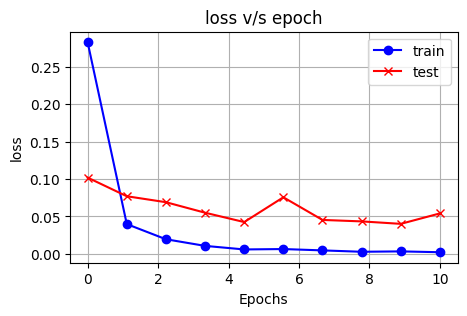

In [59]:
plot_metrics(results_mb, "loss")

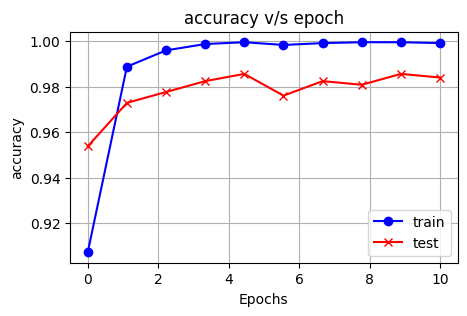

In [60]:
plot_metrics(results_mb, "accuracy")

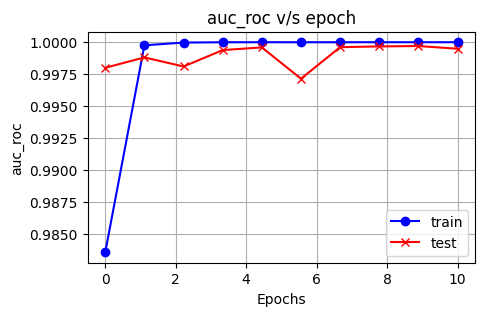

In [61]:
plot_metrics(results_mb, "auc_roc")

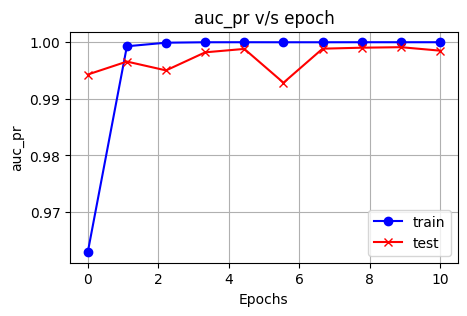

In [62]:
plot_metrics(results_mb, "auc_pr")

In [63]:
evaluation_results_mb = evaluate_performance(test_path, model_mb)

indian market
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/ste

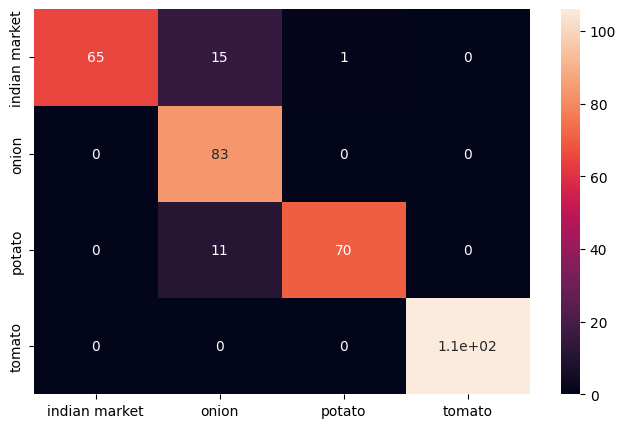

In [65]:
plt.figure(figsize=(8,5))
sns.heatmap([l for l in evaluation_results_mb[1].values()], annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

## 4. Using VGG19

In [66]:
# load base model
vgg_model = tf.keras.applications.vgg19.VGG19(input_shape=(256, 256, 3), include_top = False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [67]:
model_vgg = vgg_model.output
model_vgg = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255, input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]),
            vgg_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate = 0.1),
            tf.keras.layers.Dense(4, activation = 'softmax')
        ])

In [71]:
model_vgg.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,079,310 (229.18 MB)

 Trainable params: 20,026,436 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,052,874 (152.79 MB)

In [68]:
log_dir_tl = "logs/vgg19"

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_tl, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("vgg19.keras", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)

In [69]:
model_vgg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics = ['accuracy', auc_roc, auc_pr])

In [70]:
results_vgg = model_vgg.fit(aug_ds, validation_data = valid_ds, epochs = 10, callbacks=[tensorboard_cb, checkpoint_cb, early_stopping_cb])

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1877s 24s/step - accuracy: 0.5939 - auc_pr: 0.8235 - auc_roc: 0.9186 - loss: 0.9092 - val_accuracy: 0.8086 - val_auc_pr: 0.8922 - val_auc_roc: 0.9606 - val_loss: 0.4847
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3537s 45s/step - accuracy: 0.8545 - auc_pr: 0.9388 - auc_roc: 0.9771 - loss: 0.3562 - val_accuracy: 0.7687 - val_auc_pr: 0.8945 - val_auc_roc: 0.9587 - val_loss: 0.4771
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5887s 75s/step - accuracy: 0.8827 - auc_pr: 0.9602 - auc_roc: 0.9851 - loss: 0.2849 - val_accuracy: 0.9298 - val_auc_pr: 0.9819 - val_auc_roc: 0.9928 - val_loss: 0.1970
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4187s 53s/step - accuracy: 0.9415 - auc_pr: 0.9771 - auc_roc: 0.9916 - loss: 0.1900 - val_accuracy: 0.8788 - val_auc_pr: 0.9383 - val_auc_roc: 0.9769 - val_loss: 0.3715
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3312s 42s/step - accuracy: 0.9358 - auc_pr: 0.9847 - auc_roc: 0.9944 - loss: 0.1673 - val_accuracy: 0.9362 - val_auc_pr: 0.9821 - val_

In [72]:
model_vgg_results = model_vgg.evaluate(test_ds)
dict(zip(model_vgg.metrics_names, model_vgg_results))

11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.8874 - auc_pr: 0.9645 - auc_roc: 0.9855 - loss: 0.2970


{'loss': 0.26084020733833313, 'compile_metrics': 0.9145299196243286}

In [73]:
for i in range(5):
    image = tf.keras.utils.load_img(np.random.choice(test_images))
    image = tf.keras.utils.img_to_array(image)
    image = tf.image.resize(image, (256, 256))
    image = tf.expand_dims(image, axis = 0)
        
    pred = model_vgg.predict(image)
    predicted_label = tf.argmax(pred, 1).numpy().item()
    for i in pred:
        i = tf.round((i*100))
    print("**"*50)
    print(f"-------> Actual Label: {class_names[predicted_label]}")
    print(f"-------> Prediction %: {i[0]} - {class_names[0]}")
    print(f"-------> Prediction %: {i[1]} - {class_names[1]}")
    print(f"-------> Prediction %: {i[2]} - {class_names[2]}")
    print(f"-------> Prediction %: {i[3]} - {class_names[3]}")
    print("**"*50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
****************************************************************************************************
-------> Actual Label: tomato
-------> Prediction %: 0.0 - indian market
-------> Prediction %: 0.0 - onion
-------> Prediction %: 0.0 - potato
-------> Prediction %: 100.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
****************************************************************************************************
-------> Actual Label: onion
-------> Prediction %: 7.0 - indian market
-------> Prediction %: 67.0 - onion
-------> Prediction %: 16.0 - potato
-------> Prediction %: 10.0 - tomato
****************************************************************************************************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
****************************************************************************************************
-------> Actua

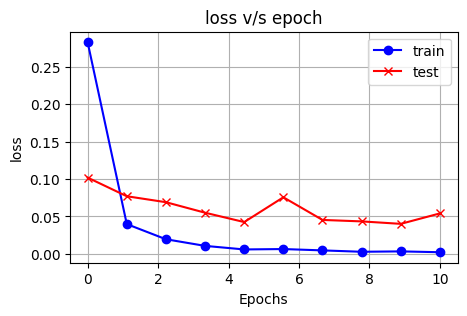

In [74]:
plot_metrics(results_mb, "loss")

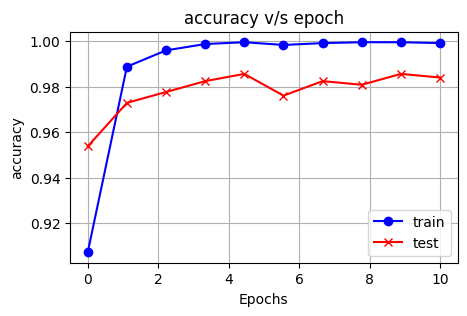

In [75]:
plot_metrics(results_mb, "accuracy")

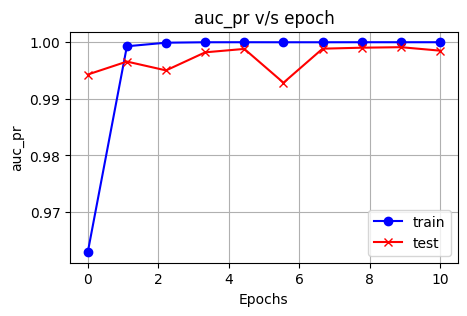

In [76]:
plot_metrics(results_mb, "auc_pr")

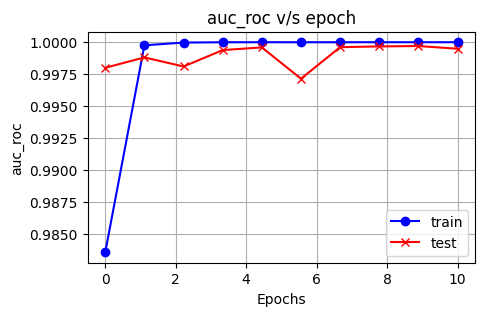

In [77]:
plot_metrics(results_mb, "auc_roc")

In [78]:
evaluation_results_vgg = evaluate_performance(test_path, model_vgg)

indian market
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━

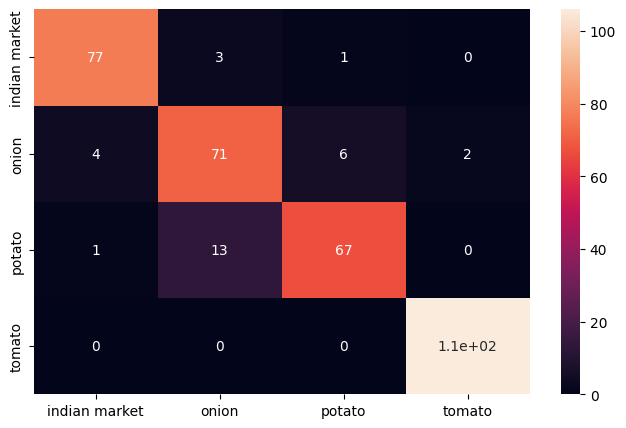

In [79]:
plt.figure(figsize=(8,5))
sns.heatmap([l for l in evaluation_results_vgg[1].values()], annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

## Summary

| Model | Test AUCPR | Loss | 
| --- | --- | ---|
| Simple CNN | 0.8109 | 0.703
| CNN with BatchNorm | 0.9102 | 0.4393
| MobileNet | 0.9715 | 0.2813
| VGG19 | 0.9645 | 0.2608 

1. **Model 1**: The simple CNN model has an AUCPR of 0.8109
2. **Model 2**: The tuned model uses a few additional layers, batch normalization, dropout and augmented image dataset which results an increase AUC from 0.81 to 0.91
3. **Model 3**: The small mobilenet model uses transfer learning method from pretrained mobilenet model, removing the top layer & with some fine-tuning gives us the best performing model with an AUCPR of 0.97.
4. **Model 4**: The final model uses transfer learning method from pretrained vgg19 model, removing the top layer & with some fine-tuning gives us the best performing model with an AUCPR of 0.9645.


**IMO, MobileNet model is the way to go. The model is is very lightweight, takes less training time (1/10th) and slightly underperforms to VGG19.**

### Results logged in tensorboard

How to use tensorboard? 

terminal command: `tensorboard --logdir path/to/logs`

<img src="results/accuracy.png" alt="Accuracy" width="500" height="300">

<img src="results/auc_roc.png" alt="ROC curve" width="500" height="300">

<img src="results/auc_pr.png" alt="PR curve" width="500" height="300">